In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/30k-movie-lens/ratings_train.npy
/kaggle/input/30k-movie-lens/namesngenre.npy
/kaggle/input/30k-movie-lens/ratings_test.npy


# NeuMF

In [3]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score

In [49]:
# NeuMF Model Definition
class NeuMF(nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()

        # MF part
        self.embedding_user_mf = nn.Embedding(config['num_users'], config['latent_dim_mf'])
        self.embedding_item_mf = nn.Embedding(config['num_items'], config['latent_dim_mf'])

        # MLP part
        self.embedding_user_mlp = nn.Embedding(config['num_users'], config['latent_dim_mlp'])
        self.embedding_item_mlp = nn.Embedding(config['num_items'], config['latent_dim_mlp'])

        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(config['layers'][:-1], config['layers'][1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # Final logits layer
        self.logits = nn.Linear(config['layers'][-1] + config['latent_dim_mf'], 1)
        self.config = config

    def forward(self, user_indices, item_indices):
        # MLP embeddings
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        # MF embeddings
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        # MF part
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)
        mf_vector = nn.Dropout(self.config['dropout_rate_mf'])(mf_vector)

        # MLP part
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        for fc in self.fc_layers:
            mlp_vector = fc(mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
        mlp_vector = nn.Dropout(self.config['dropout_rate_mlp'])(mlp_vector)

        # Concatenate MF and MLP parts
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.logits(vector)
        return logits  # Removed sigmoid for regression (continuous output)

# Custom dataset for triplet data (user, item, rating)
class RatingDataset(Dataset):
    def __init__(self, triplet_data):
        self.triplet_data = triplet_data

    def __len__(self):
        return len(self.triplet_data)

    def __getitem__(self, idx):
        user = self.triplet_data[idx, 0]
        item = self.triplet_data[idx, 1]
        rating = self.triplet_data[idx, 2]
        return torch.tensor(user, dtype=torch.long), torch.tensor(item, dtype=torch.long), torch.tensor(rating, dtype=torch.float)

# Function to convert matrix data into (user_id, item_id, rating) triplet format
def matrix_to_triplets(matrix):
    triplets = []
    num_users, num_items = matrix.shape
    for user_id in range(num_users):
        for item_id in range(num_items):
            rating = matrix[user_id, item_id]
            if not np.isnan(rating):
                triplets.append([user_id, item_id, rating])
    return np.array(triplets)

# Training function with loss tracking
def train_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    total_loss = 0
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)

        optimizer.zero_grad()
        outputs = model(users, items).squeeze()

        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Validation function to calculate validation loss
def evaluate_epoch(model, criterion, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for users, items, ratings in val_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            outputs = model(users, items).squeeze()

            loss = criterion(outputs, ratings)
            total_loss += loss.item()

    return total_loss / len(val_loader)

# Function to apply early stopping and track loss
def train_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=5):
    best_rmse = float('inf')
    epochs_no_improve = 0
    early_stop = False
    train_losses = []
    val_losses = []
    
    start_time = time.time()

    for epoch in range(config['epochs']):
        if early_stop:
            print("Early stopping...")
            break
        
        epoch_start_time = time.time()

        # Train and validate for one epoch
        train_loss = train_epoch(model, criterion, optimizer, train_loader, device)
        val_loss = evaluate_epoch(model, criterion, val_loader, device)

        # Track time for each epoch
        epoch_time = time.time() - epoch_start_time

        # Store losses for analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Validation RMSE and Accuracy calculation
        full_matrix = predict_full_matrix(model, config['num_users'], config['num_items'], device)
        rmse, accuracy = evaluate_from_matrix(full_matrix, val_triplets)  # Using validation set

        # Print all relevant metrics for the epoch
        print(f"Epoch {epoch+1}/{config['epochs']}, Time: {epoch_time:.2f}s, "
              f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
              f"Validation RMSE: {rmse:.4f}, Validation Accuracy: {accuracy:.4f}")

        # Early stopping logic
        if rmse < best_rmse:
            best_rmse = rmse
            epochs_no_improve = 0
            # Save best model state_dict
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            early_stop = True

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f}s")
    
    return train_losses, val_losses

# Predict full matrix
def predict_full_matrix(model, num_users, num_items, device):
    model.eval()
    full_matrix = np.zeros((num_users, num_items))
    with torch.no_grad():
        for user in range(num_users):
            users_batch = torch.full((num_items,), user, dtype=torch.long).to(device)
            items_batch = torch.arange(0, num_items, dtype=torch.long).to(device)
            predictions = model(users_batch, items_batch).squeeze().cpu().numpy()
            full_matrix[user, :] = predictions
    return full_matrix

# Updated function to evaluate RMSE and Accuracy using a mask from the test set
def evaluate_from_matrix(full_matrix, test_triplets):
    users = test_triplets[:, 0].astype(int)
    items = test_triplets[:, 1].astype(int)
    true_ratings = test_triplets[:, 2]

    # Apply the mask to only include non-zero or non-NaN ratings from test set
    mask = true_ratings > 0  # Assuming non-zero values are actual ratings

    # Extract the corresponding predicted and true ratings
    predicted_ratings = full_matrix[users, items][mask]
    true_ratings_filtered = true_ratings[mask]

    # Compute RMSE only for non-zero values
    rmse = np.sqrt(mean_squared_error(true_ratings_filtered, predicted_ratings))

    # Round both true and predicted ratings for accuracy calculation
    predicted_rounded = np.round(predicted_ratings)
    true_ratings_rounded = np.round(true_ratings_filtered)
    accuracy = accuracy_score(true_ratings_rounded, predicted_rounded)

    return rmse, accuracy

In [5]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 32, 16, 8],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 100,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses = train_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=8)

# After training, save the model to a file
ReuMF_model_path = "ReuMF_model.pth"  # File name for saving the model
torch.save(model.state_dict(), ReuMF_model_path)

print(f"Model saved to {ReuMF_model_path}")

# Load the model from the saved file
model = NeuMF(config).to(device)  # Re-initialize the model with the same configuration
model.load_state_dict(torch.load("ReuMF_model.pth"))

model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for inference.")

Epoch 1/100, Time: 1.23s, Training Loss: 14.6031, Validation Loss: 13.6070, Validation RMSE: 3.6829, Validation Accuracy: 0.0131
Epoch 2/100, Time: 1.22s, Training Loss: 10.0616, Validation Loss: 4.9792, Validation RMSE: 2.2476, Validation Accuracy: 0.1074
Epoch 3/100, Time: 1.07s, Training Loss: 2.8804, Validation Loss: 2.6128, Validation RMSE: 1.6199, Validation Accuracy: 0.2212
Epoch 4/100, Time: 1.07s, Training Loss: 2.2188, Validation Loss: 2.3475, Validation RMSE: 1.5289, Validation Accuracy: 0.2418
Epoch 5/100, Time: 1.06s, Training Loss: 2.0698, Validation Loss: 2.2537, Validation RMSE: 1.4966, Validation Accuracy: 0.2559
Epoch 6/100, Time: 1.06s, Training Loss: 2.0163, Validation Loss: 2.1196, Validation RMSE: 1.4647, Validation Accuracy: 0.2674
Epoch 7/100, Time: 1.06s, Training Loss: 1.9688, Validation Loss: 2.1788, Validation RMSE: 1.4714, Validation Accuracy: 0.2579
Epoch 8/100, Time: 1.07s, Training Loss: 1.9094, Validation Loss: 2.0999, Validation RMSE: 1.4426, Validatio

/tmp/ipykernel_30/3537297061.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ReuMF_model.pth"))


Completed matrix prediction.
Test RMSE: 1.1368, Test Accuracy: 0.3346


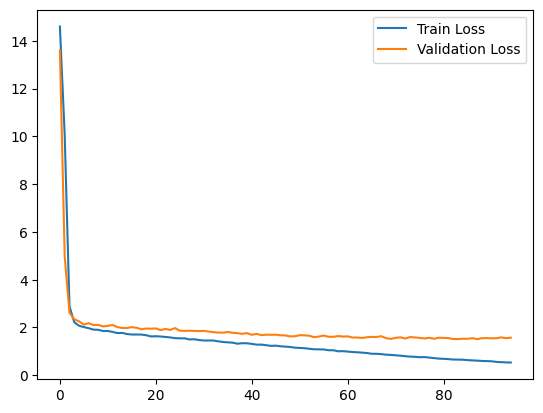

In [6]:
# Predict the entire matrix
full_matrix = predict_full_matrix(model, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

    # Evaluate from the predicted matrix
rmse, accuracy = evaluate_from_matrix(full_matrix, test_triplets)
print(f"Test RMSE: {rmse:.4f}, Test Accuracy: {accuracy:.4f}")
    
    # Plot train and validation losses (if desired)
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

#Completed matrix prediction.
# Test RMSE: 1.2016, Test Accuracy: 0.3171

In [9]:
import numpy as np

def round_to_half_integer_numpy(value):
    # Bounding without using abs() or any built-in functions
    bounded_value = value - (value < 0) * value + (value > 5) * (5 - value)
    
    # Rounding to nearest half-integer
    rounded_value = np.round(bounded_value * 2) / 2
    return rounded_value

# Assuming full_matrix is a NumPy array
full_matrix_NMF_layer4 = predict_full_matrix(model, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

# Apply the rounding function element-wise to the full matrix
rounded_full_matrix_NMF_layer4 = round_to_half_integer_numpy(full_matrix_NMF_layer4)

# Print or use the rounded matrix
print(rounded_full_matrix_NMF_layer4)

Completed matrix prediction.
[[4.5 2.5 3.5 ... 3.  3.5 5. ]
 [4.  2.5 3.  ... 5.  3.5 5. ]
 [2.  2.  1.5 ... 1.5 2.  2.5]
 ...
 [2.5 1.5 1.5 ... 3.  2.5 3. ]
 [3.  3.  2.5 ... 3.5 2.5 4.5]
 [4.  2.5 2.5 ... 3.5 3.  3.5]]


In [10]:
 # Evaluate from the predicted matrix
rmse, accuracy = evaluate_from_matrix(rounded_full_matrix_NMF_layer4, test_triplets)
print(f"Test RMSE: {rmse:.4f}, Test Accuracy: {accuracy:.4f}")

# Test RMSE: 1.1934, Test Accuracy: 0.3693

Test RMSE: 1.1280, Test Accuracy: 0.3845


In [ ]:
print(full_matrix)

Full predicted rating matrix:
[[4.5 2.5 3.5 ... 3.  3.5 5. ]
 [4.  2.5 3.  ... 5.  3.5 5. ]
 [2.  2.  1.5 ... 1.5 2.  2.5]
 ...
 [2.5 1.5 1.5 ... 3.  2.5 3. ]
 [3.  3.  2.5 ... 3.5 2.5 4.5]
 [4.  2.5 2.5 ... 3.5 3.  3.5]]


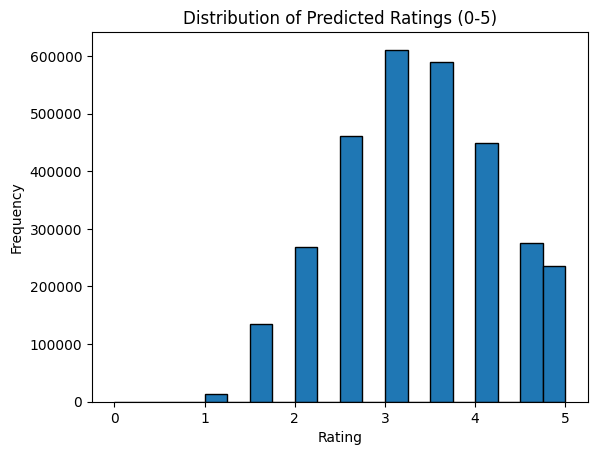

In [11]:
import matplotlib.pyplot as plt

# Function to print the full matrix and distribution of ratings
def print_matrix_and_distribution(full_matrix):
    # Print the full matrix
    print("Full predicted rating matrix:")
    print(full_matrix)

    # Flatten the matrix to get all the predicted ratings
    all_ratings = full_matrix.flatten()

    # Filter only ratings in the range of 0 to 5 (assuming ratings can be in this range)
    all_ratings_filtered = all_ratings[(all_ratings >= 0) & (all_ratings <= 5)]

    # Plot the distribution of the ratings
    plt.hist(all_ratings_filtered, bins=20, range=(0, 5), edgecolor='black')
    plt.title('Distribution of Predicted Ratings (0-5)')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

print_matrix_and_distribution(rounded_full_matrix_NMF_layer4)

Full predicted rating matrix:
[[0.000e+00 2.000e+00 4.000e+00]
 [0.000e+00 5.000e+00 4.000e+00]
 [0.000e+00 8.000e+01 5.000e+00]
 ...
 [6.090e+02 4.913e+03 4.000e+00]
 [6.090e+02 4.914e+03 3.500e+00]
 [6.090e+02 4.947e+03 3.000e+00]]


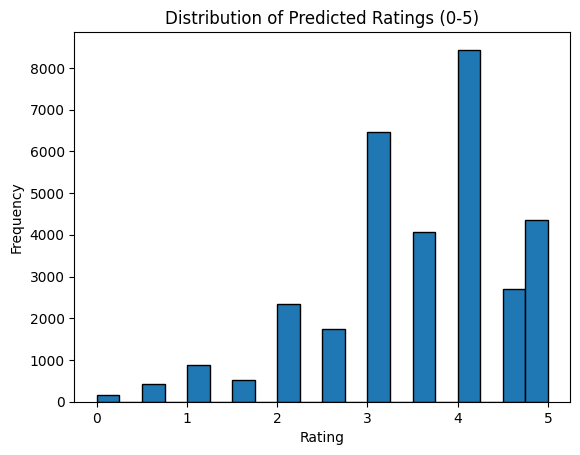

In [12]:
print_matrix_and_distribution(test_triplets)

In [11]:
genre = np.load('/kaggle/input/30k-movie-lens/namesngenre.npy')
print(genre)

[['Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy']
 ['Jumanji (1995)' 'Adventure|Children|Fantasy']
 ['Grumpier Old Men (1995)' 'Comedy|Romance']
 ...
 ['Elsa & Fred (2005)' 'Comedy|Drama|Romance']
 ['Tomb Raider (2018)' 'Action|Adventure|Fantasy']
 ['Fred Armisen: Standup for Drummers (2018)' 'Comedy']]


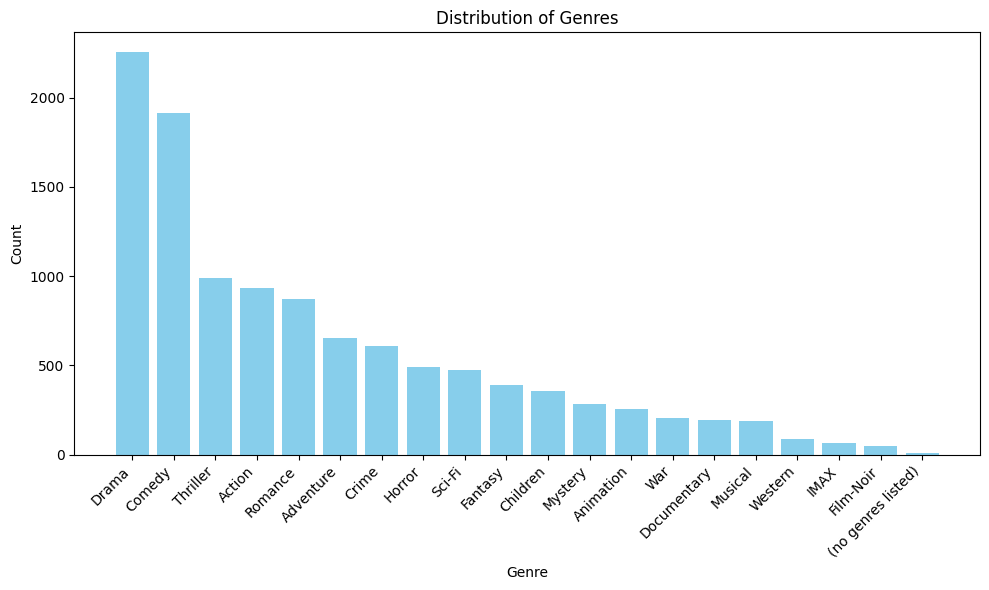

                 Genre  Count
6                Drama   2253
3               Comedy   1916
9             Thriller    991
7               Action    931
5              Romance    871
0            Adventure    651
8                Crime    606
10              Horror    493
12              Sci-Fi    476
4              Fantasy    388
2             Children    358
11             Mystery    283
1            Animation    257
13                 War    203
15         Documentary    196
14             Musical    188
17             Western     88
16                IMAX     66
18           Film-Noir     50
19  (no genres listed)      8


In [12]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Load the genre data from your file
genre_data = np.load('/kaggle/input/30k-movie-lens/namesngenre.npy', allow_pickle=True)

# Split the genres by '|' and count the occurrences of each genre
all_genres = [genre for movie, genre_list in genre_data for genre in genre_list.split('|')]

# Count the frequency of each genre
genre_counter = Counter(all_genres)

# Convert the genre distribution to a DataFrame for better visualization
genre_distribution_df = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Count'])

# Sort the genres by frequency
genre_distribution_df = genre_distribution_df.sort_values(by='Count', ascending=False)

# Plot the genre distribution
plt.figure(figsize=(10, 6))
plt.bar(genre_distribution_df['Genre'], genre_distribution_df['Count'], color='skyblue')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot and the genre distribution
plt.show()

# Print genre distribution DataFrame
print(genre_distribution_df)

## num of layer 2

In [ ]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 32],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 100,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses = train_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=8)


# RoundNet

In [13]:
# Sigmoid-based approximation for the staircase function using PyTorch
def sigmoid_approx_torch(x, steps=5, k=10):
    approximation = torch.zeros_like(x)  # Initialize with zeros
    for n in range(steps):
        x_n = 0.5 + n
        A_n = 1
        approximation += A_n * torch.sigmoid(k * (x - x_n))
    return approximation

In [14]:
class NeuMF(nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()

        # MF part
        self.embedding_user_mf = nn.Embedding(config['num_users'], config['latent_dim_mf'])
        self.embedding_item_mf = nn.Embedding(config['num_items'], config['latent_dim_mf'])

        # MLP part
        self.embedding_user_mlp = nn.Embedding(config['num_users'], config['latent_dim_mlp'])
        self.embedding_item_mlp = nn.Embedding(config['num_items'], config['latent_dim_mlp'])

        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(config['layers'][:-1], config['layers'][1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # Final logits layer
        self.logits = nn.Linear(config['layers'][-1] + config['latent_dim_mf'], 1)
        self.config = config

    def forward(self, user_indices, item_indices):
        # MLP embeddings
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        # MF embeddings
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        # MF part
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)
        mf_vector = nn.Dropout(self.config['dropout_rate_mf'])(mf_vector)

        # MLP part
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        for fc in self.fc_layers:
            mlp_vector = fc(mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
        mlp_vector = nn.Dropout(self.config['dropout_rate_mlp'])(mlp_vector)

        # Concatenate MF and MLP parts
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.logits(vector)
        
        # Scale the logits to [0, 5] before applying the sigmoid approximation
        scaled_logits = 2.5 * (torch.tanh(logits) + 1)

        # Apply sigmoid-based approximation
        rounded_output = sigmoid_approx_torch(scaled_logits, steps=5, k=10)
        return rounded_output

In [15]:
# Custom dataset for triplet data (user, item, rating)
class RatingDataset(Dataset):
    def __init__(self, triplet_data):
        self.triplet_data = triplet_data

    def __len__(self):
        return len(self.triplet_data)

    def __getitem__(self, idx):
        user = self.triplet_data[idx, 0]
        item = self.triplet_data[idx, 1]
        rating = self.triplet_data[idx, 2]
        return torch.tensor(user, dtype=torch.long), torch.tensor(item, dtype=torch.long), torch.tensor(rating, dtype=torch.float)

# Function to convert matrix data into (user_id, item_id, rating) triplet format
def matrix_to_triplets(matrix):
    triplets = []
    num_users, num_items = matrix.shape
    for user_id in range(num_users):
        for item_id in range(num_items):
            rating = matrix[user_id, item_id]
            if not np.isnan(rating):
                triplets.append([user_id, item_id, rating])
    return np.array(triplets)

# Training function with loss tracking
def train_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    total_loss = 0
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)

        optimizer.zero_grad()
        outputs = model(users, items).squeeze()

        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Validation function to calculate validation loss
def evaluate_epoch(model, criterion, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for users, items, ratings in val_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            outputs = model(users, items).squeeze()

            loss = criterion(outputs, ratings)
            total_loss += loss.item()

    return total_loss / len(val_loader)

# Function to apply early stopping and track loss
def train_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=5):
    best_rmse = float('inf')
    best_accuracy = 0
    epochs_no_improve = 0
    early_stop = False
    train_losses = []
    val_losses = []
    val_rmses = []      # To store validation RMSEs
    val_accuracies = [] # To store validation Accuracies

    start_time = time.time()

    for epoch in range(config['epochs']):
        if early_stop:
            print("Early stopping...")
            break
        
        epoch_start_time = time.time()

        # Train and validate for one epoch
        train_loss = train_epoch(model, criterion, optimizer, train_loader, device)
        val_loss = evaluate_epoch(model, criterion, val_loader, device)

        # Track time for each epoch
        epoch_time = time.time() - epoch_start_time

        # Store losses for analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Validation RMSE and Accuracy calculation
        full_matrix = predict_full_matrix(model, config['num_users'], config['num_items'], device)
        rmse, accuracy = evaluate_from_matrix(full_matrix, val_triplets)  # Using validation set

        # Store RMSE and Accuracy for analysis
        val_rmses.append(rmse)
        val_accuracies.append(accuracy)

        # Print all relevant metrics for the epoch
        print(f"Epoch {epoch+1}/{config['epochs']}, Time: {epoch_time:.2f}s, "
              f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
              f"Validation RMSE: {rmse:.4f}, Validation Accuracy: {accuracy:.4f}")

        # Early stopping logic
        if accuracy < best_accuracy:
            best_accuracy = accuracy
            epochs_no_improve = 0
            # Save best model state_dict
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            early_stop = True

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f}s")
    
    return train_losses, val_losses, val_rmses, val_accuracies

# Predict full matrix
def predict_full_matrix(model, num_users, num_items, device):
    model.eval()
    full_matrix = np.zeros((num_users, num_items))
    with torch.no_grad():
        for user in range(num_users):
            users_batch = torch.full((num_items,), user, dtype=torch.long).to(device)
            items_batch = torch.arange(0, num_items, dtype=torch.long).to(device)
            predictions = model(users_batch, items_batch).squeeze().cpu().numpy()
            full_matrix[user, :] = predictions
    return full_matrix

# Updated function to evaluate RMSE and Accuracy using a mask from the test set
def evaluate_from_matrix(full_matrix, test_triplets):
    users = test_triplets[:, 0].astype(int)
    items = test_triplets[:, 1].astype(int)
    true_ratings = test_triplets[:, 2]

    # Apply the mask to only include non-zero or non-NaN ratings from test set
    mask = true_ratings > 0  # Assuming non-zero values are actual ratings

    # Extract the corresponding predicted and true ratings
    predicted_ratings = full_matrix[users, items][mask]
    true_ratings_filtered = true_ratings[mask]

    # Compute RMSE only for non-zero values
    rmse = np.sqrt(mean_squared_error(true_ratings_filtered, predicted_ratings))

    # Round both true and predicted ratings for accuracy calculation
    predicted_rounded = np.round(predicted_ratings)
    true_ratings_rounded = np.round(true_ratings_filtered)
    accuracy = accuracy_score(true_ratings_rounded, predicted_rounded)

    return rmse, accuracy

In [16]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 32, 16, 8],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 200,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses, val_rmses, val_accuracies = train_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=50)

Epoch 1/200, Time: 1.12s, Training Loss: 1.9411, Validation Loss: 1.5366, Validation RMSE: 1.2363, Validation Accuracy: 0.3462
Epoch 2/200, Time: 1.11s, Training Loss: 1.4139, Validation Loss: 1.3966, Validation RMSE: 1.1933, Validation Accuracy: 0.3722
Epoch 3/200, Time: 1.11s, Training Loss: 1.2306, Validation Loss: 1.3229, Validation RMSE: 1.1649, Validation Accuracy: 0.3791
Epoch 4/200, Time: 1.10s, Training Loss: 1.1128, Validation Loss: 1.2972, Validation RMSE: 1.1483, Validation Accuracy: 0.3927
Epoch 5/200, Time: 1.11s, Training Loss: 1.0405, Validation Loss: 1.2630, Validation RMSE: 1.1372, Validation Accuracy: 0.3941
Epoch 6/200, Time: 1.19s, Training Loss: 0.9845, Validation Loss: 1.2642, Validation RMSE: 1.1352, Validation Accuracy: 0.3832
Epoch 7/200, Time: 1.11s, Training Loss: 0.9446, Validation Loss: 1.2730, Validation RMSE: 1.1342, Validation Accuracy: 0.4013
Epoch 8/200, Time: 1.41s, Training Loss: 0.9122, Validation Loss: 1.2501, Validation RMSE: 1.1353, Validation A

In [17]:
# Predict the entire matrix
full_matrix_RN_layer4 = predict_full_matrix(model, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

    # Evaluate from the predicted matrix
rmse, accuracy = evaluate_from_matrix(full_matrix_RN_layer4, test_triplets)
print(f"Test RMSE: {rmse:.4f}, Test Accuracy: {accuracy:.4f}")

print(accuracy)

Completed matrix prediction.
Test RMSE: 1.0669, Test Accuracy: 0.3980
0.3979682258370783


Completed matrix prediction.
Test RMSE: 1.0885, Test Accuracy: 0.4085
0.4084752199506298


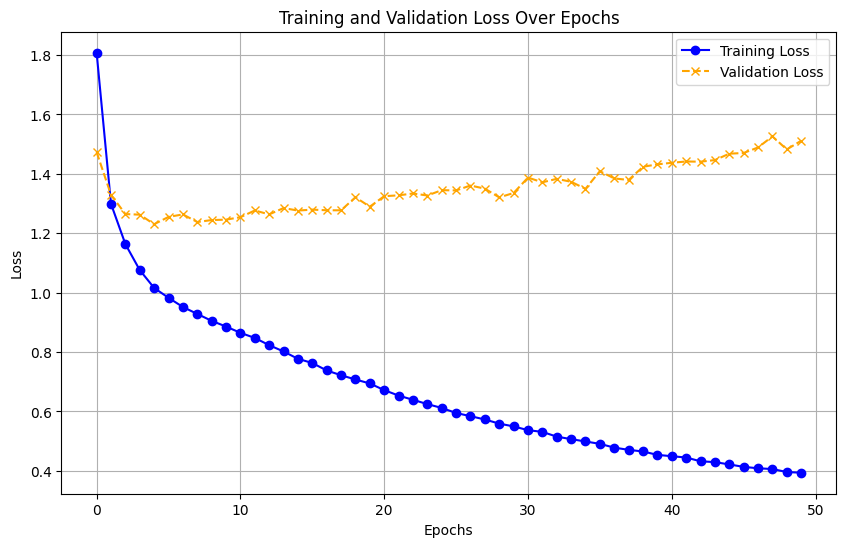

In [26]:
    # Plot train and validation losses (if desired)
import matplotlib.pyplot as plt
# Plotting the losses
plt.figure(figsize=(10, 6))  # Optionally set figure size
plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o')
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--', marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)  # Optional: adds a grid for better readability
plt.show()

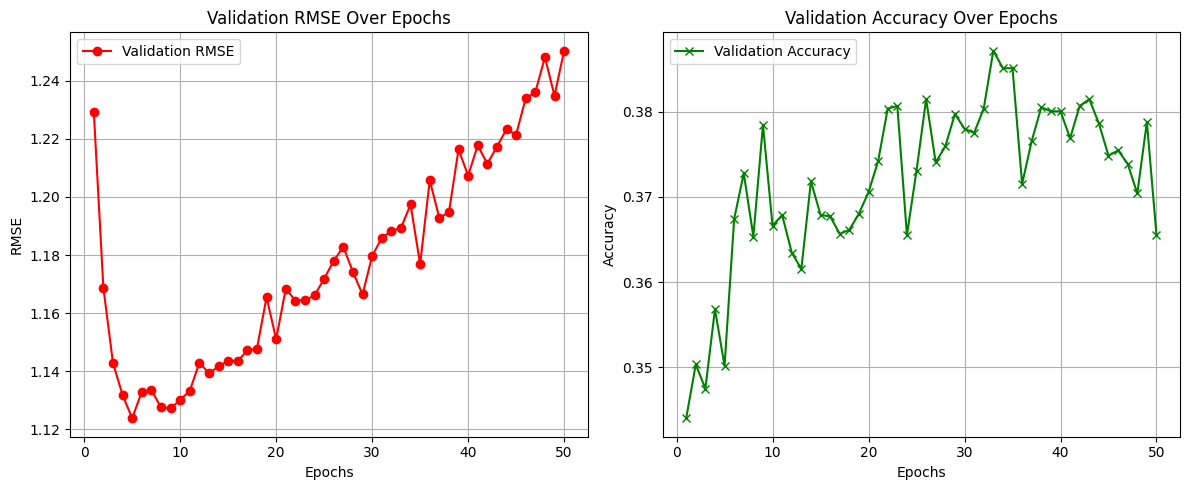

In [27]:
import matplotlib.pyplot as plt

# Function to plot validation RMSEs and validation Accuracies
def plot_metrics(val_rmses, val_accuracies):
    epochs = range(1, len(val_rmses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot RMSE
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_rmses, label='Validation RMSE', color='red', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.title("Validation RMSE Over Epochs")
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics(val_rmses, val_accuracies)  # Uncomment and pass in the tracked lists of RMSE and accuracy

In [18]:
import numpy as np

def round_to_half_integer_numpy(value):
    # Bounding without using abs() or any built-in functions
    bounded_value = value - (value < 0) * value + (value > 5) * (5 - value)
    
    # Rounding to nearest half-integer
    rounded_value = np.round(bounded_value * 2) / 2
    return rounded_value

# Assuming full_matrix is a NumPy array
full_matrix = predict_full_matrix(model, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

# Apply the rounding function element-wise to the full matrix
rounded_full_matrix = round_to_half_integer_numpy(full_matrix)

# Print or use the rounded matrix
print(rounded_full_matrix)

Completed matrix prediction.
[[4.  3.5 4.  ... 5.  4.  4. ]
 [3.  4.  3.5 ... 3.  3.5 4. ]
 [1.  1.5 1.  ... 2.  2.  2. ]
 ...
 [3.  3.  3.  ... 3.  3.  5. ]
 [4.  3.  2.5 ... 4.  3.  3.5]
 [4.  4.  3.5 ... 3.5 4.  4. ]]


In [19]:
 # Evaluate from the predicted matrix
rmse, accuracy = evaluate_from_matrix(full_matrix, test_triplets)
print(f"Test RMSE: {rmse:.4f}, Test Accuracy: {accuracy:.4f}")

# Test RMSE: 1.1934, Test Accuracy: 0.3693

Test RMSE: 1.0625, Test Accuracy: 0.4003


# compare diff dist.

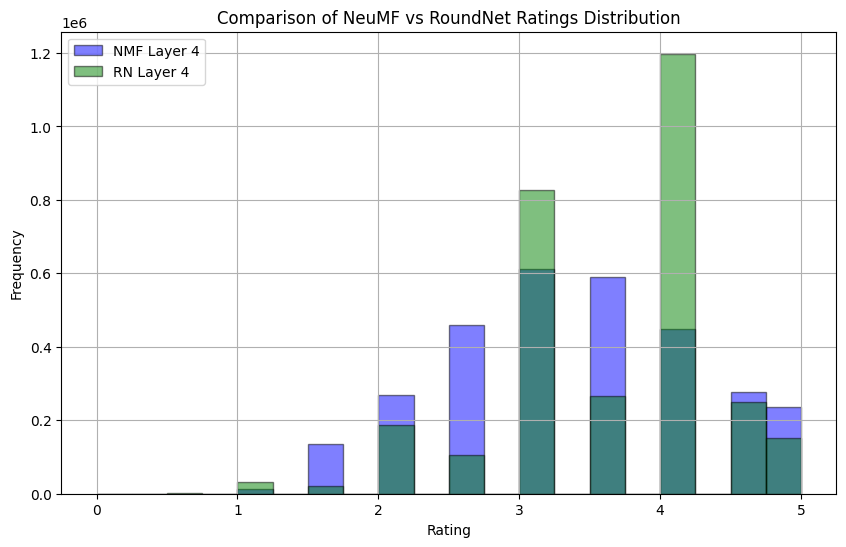

In [33]:
import matplotlib.pyplot as plt

# Function to plot the distribution of ratings for rounded_full_matrix_NMF and rounded_full_matrix_RN
def compare_distributions_NMF_RN(rounded_full_matrix_NMF, rounded_full_matrix_RN):
    plt.figure(figsize=(10, 6))

    # Flatten the matrices and filter ratings between 0 and 5
    all_ratings_NMF = rounded_full_matrix_NMF.flatten()
    all_ratings_NMF_filtered = all_ratings_NMF[(all_ratings_NMF >= 0) & (all_ratings_NMF <= 5)]

    all_ratings_RN = rounded_full_matrix_RN.flatten()
    all_ratings_RN_filtered = all_ratings_RN[(all_ratings_RN >= 0) & (all_ratings_RN <= 5)]

    # Plot the histograms for comparison
    plt.hist(all_ratings_NMF_filtered, bins=20, range=(0, 5), edgecolor='black', alpha=0.5, label='NMF Layer 4', color='blue')
    plt.hist(all_ratings_RN_filtered, bins=20, range=(0, 5), edgecolor='black', alpha=0.5, label='RN Layer 4', color='green')

    plt.title('Comparison of NeuMF vs RoundNet Ratings Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
compare_distributions_NMF_RN(rounded_full_matrix_NMF_layer4, rounded_full_matrix_RN_layer4)

# Different layers (3,4,5,6) of RMSE / Accuracy

## RroundNet

In [35]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 32, 16],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 200,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_RN_layer3 = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model_RN_layer3.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses, val_rmses, val_accuracies = train_with_early_stopping(model_RN_layer3, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=50)

Epoch 1/200, Time: 1.09s, Training Loss: 1.8592, Validation Loss: 1.5137, Validation RMSE: 1.2405, Validation Accuracy: 0.3408
Epoch 2/200, Time: 1.14s, Training Loss: 1.3451, Validation Loss: 1.3412, Validation RMSE: 1.1749, Validation Accuracy: 0.3581
Epoch 3/200, Time: 1.42s, Training Loss: 1.1603, Validation Loss: 1.2867, Validation RMSE: 1.1457, Validation Accuracy: 0.3560
Epoch 4/200, Time: 1.12s, Training Loss: 1.0719, Validation Loss: 1.2515, Validation RMSE: 1.1283, Validation Accuracy: 0.3541
Epoch 5/200, Time: 1.16s, Training Loss: 1.0059, Validation Loss: 1.2365, Validation RMSE: 1.1254, Validation Accuracy: 0.3739
Epoch 6/200, Time: 1.17s, Training Loss: 0.9682, Validation Loss: 1.2227, Validation RMSE: 1.1161, Validation Accuracy: 0.3538
Epoch 7/200, Time: 1.29s, Training Loss: 0.9323, Validation Loss: 1.2128, Validation RMSE: 1.1080, Validation Accuracy: 0.3668
Epoch 8/200, Time: 1.12s, Training Loss: 0.9129, Validation Loss: 1.1932, Validation RMSE: 1.1074, Validation A

In [43]:
# Predict the entire matrix
full_matrix_RN_layer3 = predict_full_matrix(model_RN_layer3, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

# Apply the rounding function element-wise to the full matrix
round_full_matrix_RN_layer3 = round_to_half_integer_numpy(full_matrix_RN_layer3)

    # Evaluate from the predicted matrix
rmse_RN_layer3, accuracy_RN_layer3 = evaluate_from_matrix(round_full_matrix_RN_layer3, test_triplets)
print(f"Test RMSE RN_layer3: {rmse_RN_layer3:.4f}, Test Accuracy RN_layer3: {accuracy_RN_layer3:.4f}")

#Completed matrix prediction.
#Test RMSE RN_layer3: 1.0661, Test Accuracy RN_layer3: 0.4225

Completed matrix prediction.
Test RMSE RN_layer3: 1.0661, Test Accuracy RN_layer3: 0.4225


### layer 5

In [38]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 128, 32, 16, 8 ],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 200,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_RN_layer5 = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model_RN_layer5.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses, val_rmses, val_accuracies = train_with_early_stopping(model_RN_layer5, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=50)

Epoch 1/200, Time: 1.22s, Training Loss: 2.7788, Validation Loss: 1.9429, Validation RMSE: 1.4003, Validation Accuracy: 0.3267
Epoch 2/200, Time: 1.16s, Training Loss: 1.6704, Validation Loss: 1.7091, Validation RMSE: 1.3065, Validation Accuracy: 0.3361
Epoch 3/200, Time: 1.18s, Training Loss: 1.3986, Validation Loss: 1.5174, Validation RMSE: 1.2396, Validation Accuracy: 0.3324
Epoch 4/200, Time: 1.75s, Training Loss: 1.2069, Validation Loss: 1.4384, Validation RMSE: 1.2041, Validation Accuracy: 0.3337
Epoch 5/200, Time: 1.21s, Training Loss: 1.1425, Validation Loss: 1.4211, Validation RMSE: 1.2014, Validation Accuracy: 0.3253
Epoch 6/200, Time: 1.26s, Training Loss: 1.0934, Validation Loss: 1.4470, Validation RMSE: 1.2069, Validation Accuracy: 0.3198
Epoch 7/200, Time: 1.33s, Training Loss: 1.0460, Validation Loss: 1.4576, Validation RMSE: 1.2241, Validation Accuracy: 0.3222
Epoch 8/200, Time: 1.24s, Training Loss: 1.0106, Validation Loss: 1.4291, Validation RMSE: 1.2028, Validation A

In [39]:
# Predict the entire matrix
full_matrix_RN_layer5 = predict_full_matrix(model_RN_layer5, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

# Apply the rounding function element-wise to the full matrix
round_full_matrix_RN_layer5 = round_to_half_integer_numpy(full_matrix_RN_layer5)

    # Evaluate from the predicted matrix
rmse_RN_layer5, accuracy_RN_layer5 = evaluate_from_matrix(round_full_matrix_RN_layer5, test_triplets)
print(f"Test RMSE RN_layer5: {rmse_RN_layer5:.4f}, Test Accuracy RN_layer5: {accuracy_RN_layer5:.4f}")


#Completed matrix prediction.
#Test RMSE RN_layer5: 1.1129, Test Accuracy RN_layer5: 0.4081

Completed matrix prediction.
Test RMSE RN_layer5: 1.1129, Test Accuracy RN_layer5: 0.4081


### layer 6

In [45]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 128,64, 32, 16, 8 ],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 200,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_RN_layer6 = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model_RN_layer6.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses, val_rmses, val_accuracies = train_with_early_stopping(model_RN_layer6, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=50)

Epoch 1/200, Time: 1.28s, Training Loss: 2.1016, Validation Loss: 1.5719, Validation RMSE: 1.2696, Validation Accuracy: 0.3631
Epoch 2/200, Time: 1.23s, Training Loss: 1.3670, Validation Loss: 1.3450, Validation RMSE: 1.1795, Validation Accuracy: 0.3541
Epoch 3/200, Time: 1.31s, Training Loss: 1.1984, Validation Loss: 1.2553, Validation RMSE: 1.1249, Validation Accuracy: 0.3427
Epoch 4/200, Time: 1.20s, Training Loss: 1.0975, Validation Loss: 1.2033, Validation RMSE: 1.1060, Validation Accuracy: 0.3592
Epoch 5/200, Time: 1.23s, Training Loss: 1.0343, Validation Loss: 1.1759, Validation RMSE: 1.0950, Validation Accuracy: 0.3528
Epoch 6/200, Time: 1.19s, Training Loss: 0.9808, Validation Loss: 1.1684, Validation RMSE: 1.0844, Validation Accuracy: 0.3628
Epoch 7/200, Time: 1.19s, Training Loss: 0.9505, Validation Loss: 1.1619, Validation RMSE: 1.0787, Validation Accuracy: 0.3584
Epoch 8/200, Time: 1.56s, Training Loss: 0.9150, Validation Loss: 1.1453, Validation RMSE: 1.0708, Validation A

In [47]:
# Predict the entire matrix
full_matrix_RN_layer6 = predict_full_matrix(model_RN_layer6, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

# Apply the rounding function element-wise to the full matrix
round_full_matrix_RN_layer6 = round_to_half_integer_numpy(full_matrix_RN_layer6)

    # Evaluate from the predicted matrix
rmse_RN_layer6, accuracy_RN_layer6 = evaluate_from_matrix(full_matrix_RN_layer6, test_triplets)
print(f"Test RMSE RN_layer6: {rmse_RN_layer6:.4f}, Test Accuracy RN_layer6: {accuracy_RN_layer6:.4f}")


Completed matrix prediction.
Test RMSE RN_layer6: 1.1265, Test Accuracy RN_layer6: 0.3894


## NeuMF

In [50]:
# NeuMF Model Definition
class NeuMF(nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()

        # MF part
        self.embedding_user_mf = nn.Embedding(config['num_users'], config['latent_dim_mf'])
        self.embedding_item_mf = nn.Embedding(config['num_items'], config['latent_dim_mf'])

        # MLP part
        self.embedding_user_mlp = nn.Embedding(config['num_users'], config['latent_dim_mlp'])
        self.embedding_item_mlp = nn.Embedding(config['num_items'], config['latent_dim_mlp'])

        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(config['layers'][:-1], config['layers'][1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # Final logits layer
        self.logits = nn.Linear(config['layers'][-1] + config['latent_dim_mf'], 1)
        self.config = config

    def forward(self, user_indices, item_indices):
        # MLP embeddings
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        # MF embeddings
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        # MF part
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)
        mf_vector = nn.Dropout(self.config['dropout_rate_mf'])(mf_vector)

        # MLP part
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        for fc in self.fc_layers:
            mlp_vector = fc(mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
        mlp_vector = nn.Dropout(self.config['dropout_rate_mlp'])(mlp_vector)

        # Concatenate MF and MLP parts
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.logits(vector)
        return logits  # Removed sigmoid for regression (continuous output)

# Custom dataset for triplet data (user, item, rating)
class RatingDataset(Dataset):
    def __init__(self, triplet_data):
        self.triplet_data = triplet_data

    def __len__(self):
        return len(self.triplet_data)

    def __getitem__(self, idx):
        user = self.triplet_data[idx, 0]
        item = self.triplet_data[idx, 1]
        rating = self.triplet_data[idx, 2]
        return torch.tensor(user, dtype=torch.long), torch.tensor(item, dtype=torch.long), torch.tensor(rating, dtype=torch.float)

# Function to convert matrix data into (user_id, item_id, rating) triplet format
def matrix_to_triplets(matrix):
    triplets = []
    num_users, num_items = matrix.shape
    for user_id in range(num_users):
        for item_id in range(num_items):
            rating = matrix[user_id, item_id]
            if not np.isnan(rating):
                triplets.append([user_id, item_id, rating])
    return np.array(triplets)

# Training function with loss tracking
def train_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    total_loss = 0
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)

        optimizer.zero_grad()
        outputs = model(users, items).squeeze()

        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Validation function to calculate validation loss
def evaluate_epoch(model, criterion, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for users, items, ratings in val_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            outputs = model(users, items).squeeze()

            loss = criterion(outputs, ratings)
            total_loss += loss.item()

    return total_loss / len(val_loader)

# Function to apply early stopping and track loss
def train_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=5):
    best_rmse = float('inf')
    epochs_no_improve = 0
    early_stop = False
    train_losses = []
    val_losses = []
    
    start_time = time.time()

    for epoch in range(config['epochs']):
        if early_stop:
            print("Early stopping...")
            break
        
        epoch_start_time = time.time()

        # Train and validate for one epoch
        train_loss = train_epoch(model, criterion, optimizer, train_loader, device)
        val_loss = evaluate_epoch(model, criterion, val_loader, device)

        # Track time for each epoch
        epoch_time = time.time() - epoch_start_time

        # Store losses for analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Validation RMSE and Accuracy calculation
        full_matrix = predict_full_matrix(model, config['num_users'], config['num_items'], device)
        rmse, accuracy = evaluate_from_matrix(full_matrix, val_triplets)  # Using validation set

        # Print all relevant metrics for the epoch
        print(f"Epoch {epoch+1}/{config['epochs']}, Time: {epoch_time:.2f}s, "
              f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
              f"Validation RMSE: {rmse:.4f}, Validation Accuracy: {accuracy:.4f}")

        # Early stopping logic
        if rmse < best_rmse:
            best_rmse = rmse
            epochs_no_improve = 0
            # Save best model state_dict
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            early_stop = True

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f}s")
    
    return train_losses, val_losses

# Predict full matrix
def predict_full_matrix(model, num_users, num_items, device):
    model.eval()
    full_matrix = np.zeros((num_users, num_items))
    with torch.no_grad():
        for user in range(num_users):
            users_batch = torch.full((num_items,), user, dtype=torch.long).to(device)
            items_batch = torch.arange(0, num_items, dtype=torch.long).to(device)
            predictions = model(users_batch, items_batch).squeeze().cpu().numpy()
            full_matrix[user, :] = predictions
    return full_matrix

# Updated function to evaluate RMSE and Accuracy using a mask from the test set
def evaluate_from_matrix(full_matrix, test_triplets):
    users = test_triplets[:, 0].astype(int)
    items = test_triplets[:, 1].astype(int)
    true_ratings = test_triplets[:, 2]

    # Apply the mask to only include non-zero or non-NaN ratings from test set
    mask = true_ratings > 0  # Assuming non-zero values are actual ratings

    # Extract the corresponding predicted and true ratings
    predicted_ratings = full_matrix[users, items][mask]
    true_ratings_filtered = true_ratings[mask]

    # Compute RMSE only for non-zero values
    rmse = np.sqrt(mean_squared_error(true_ratings_filtered, predicted_ratings))

    # Round both true and predicted ratings for accuracy calculation
    predicted_rounded = np.round(predicted_ratings)
    true_ratings_rounded = np.round(true_ratings_filtered)
    accuracy = accuracy_score(true_ratings_rounded, predicted_rounded)

    return rmse, accuracy

In [51]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 32, 16],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 100,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_NM_layer3 = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model_NM_layer3.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses = train_with_early_stopping(model_NM_layer3, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=8)

Epoch 1/100, Time: 1.06s, Training Loss: 10.4841, Validation Loss: 6.5853, Validation RMSE: 2.5699, Validation Accuracy: 0.0646
Epoch 2/100, Time: 1.12s, Training Loss: 3.2503, Validation Loss: 2.0220, Validation RMSE: 1.4349, Validation Accuracy: 0.2328
Epoch 3/100, Time: 1.17s, Training Loss: 1.7091, Validation Loss: 1.7653, Validation RMSE: 1.3203, Validation Accuracy: 0.2573
Epoch 4/100, Time: 1.09s, Training Loss: 1.5345, Validation Loss: 1.6720, Validation RMSE: 1.2974, Validation Accuracy: 0.2788
Epoch 5/100, Time: 1.09s, Training Loss: 1.4515, Validation Loss: 1.6176, Validation RMSE: 1.2870, Validation Accuracy: 0.2682
Epoch 6/100, Time: 1.12s, Training Loss: 1.3820, Validation Loss: 1.6135, Validation RMSE: 1.2773, Validation Accuracy: 0.2861
Epoch 7/100, Time: 1.08s, Training Loss: 1.3481, Validation Loss: 1.5873, Validation RMSE: 1.2484, Validation Accuracy: 0.2945
Epoch 8/100, Time: 1.36s, Training Loss: 1.3151, Validation Loss: 1.5550, Validation RMSE: 1.2579, Validation 

In [53]:
# Predict the entire matrix
full_matrix_NM_layer3 = predict_full_matrix(model_NM_layer3, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

# Apply the rounding function element-wise to the full matrix
round_full_matrix_NM_layer3 = round_to_half_integer_numpy(full_matrix_NM_layer3)

    # Evaluate from the predicted matrix
rmse_NM_layer3, accuracy_NM_layer3 = evaluate_from_matrix(full_matrix_NM_layer3, test_triplets)
print(f"Test RMSE NM_layer3: {rmse_NM_layer3:.4f}, Test Accuracy NM_layer3: {accuracy_NM_layer3:.4f}")

# Test RMSE NM_layer3: 1.0963, Test Accuracy NM_layer3: 0.3501

Completed matrix prediction.
Test RMSE NM_layer3: 1.0963, Test Accuracy NM_layer3: 0.3501


### layer 5

In [55]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 128, 32, 16, 8 ],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 100,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_NM_layer5 = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model_NM_layer5.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses = train_with_early_stopping(model_NM_layer5, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=8)

Epoch 1/100, Time: 1.23s, Training Loss: 10.3767, Validation Loss: 3.8237, Validation RMSE: 1.9683, Validation Accuracy: 0.1560
Epoch 2/100, Time: 1.19s, Training Loss: 2.9269, Validation Loss: 2.5552, Validation RMSE: 1.6250, Validation Accuracy: 0.2831
Epoch 3/100, Time: 1.15s, Training Loss: 2.5105, Validation Loss: 2.5345, Validation RMSE: 1.6172, Validation Accuracy: 0.2927
Epoch 4/100, Time: 1.13s, Training Loss: 2.4187, Validation Loss: 2.5192, Validation RMSE: 1.5868, Validation Accuracy: 0.3085
Epoch 5/100, Time: 1.25s, Training Loss: 2.3504, Validation Loss: 2.4718, Validation RMSE: 1.5621, Validation Accuracy: 0.3141
Epoch 6/100, Time: 1.40s, Training Loss: 2.3413, Validation Loss: 2.3891, Validation RMSE: 1.5491, Validation Accuracy: 0.3153
Epoch 7/100, Time: 1.16s, Training Loss: 2.2788, Validation Loss: 2.3763, Validation RMSE: 1.5674, Validation Accuracy: 0.3141
Epoch 8/100, Time: 1.16s, Training Loss: 2.2178, Validation Loss: 2.3714, Validation RMSE: 1.5477, Validation 

In [58]:
# Predict the entire matrix
full_matrix_NM_layer5 = predict_full_matrix(model_NM_layer5, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

# Apply the rounding function element-wise to the full matrix
round_full_matrix_NM_layer5 = round_to_half_integer_numpy(full_matrix_NM_layer5)

    # Evaluate from the predicted matrix
rmse_NM_layer5, accuracy_NM_layer5 = evaluate_from_matrix(full_matrix_NM_layer5, test_triplets)
print(f"Test RMSE NM_layer5: {rmse_NM_layer5:.4f}, Test Accuracy NM_layer5: {accuracy_NM_layer5:.4f}")

# Test RMSE NM_layer5: 1.2034, Test Accuracy NM_layer5: 0.3130

Completed matrix prediction.
Test RMSE NM_layer5: 1.2034, Test Accuracy NM_layer5: 0.3130


### layer 6

In [59]:
# Configuration
config = {
        'num_users': 610,  # Adjust based on your dataset
        'num_items': 4980,  # Adjust based on your dataset
        'latent_dim_mf': 8,
        'latent_dim_mlp': 32,
        'layers': [64, 128,64, 32, 16, 8 ],  # MLP layer sizes
        'dropout_rate_mf': 0.2,
        'dropout_rate_mlp': 0.2,
        'lr': 0.001,
        'batch_size': 512,
        'epochs': 100,
    }

    # Load your dataset from .npy files
train_data = np.load('/kaggle/input/30k-movie-lens/ratings_train.npy')
test_data = np.load('/kaggle/input/30k-movie-lens/ratings_test.npy')

    # Convert to (user, item, rating) triplet format
train_triplets = matrix_to_triplets(train_data)
test_triplets = matrix_to_triplets(test_data)

    # Split validation data from training data (80% train, 20% val)
split_idx = int(0.8 * len(train_triplets))
val_triplets = train_triplets[split_idx:]
train_triplets = train_triplets[:split_idx]

    # Create Dataset and DataLoader objects
train_dataset = RatingDataset(train_triplets)
val_dataset = RatingDataset(val_triplets)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_NM_layer6 = NeuMF(config).to(device)
criterion = nn.MSELoss()  # Use MSELoss for predicting continuous ratings
optimizer = optim.Adam(model_NM_layer6.parameters(), lr=config['lr'])

    # Train model with early stopping and loss tracking
train_losses, val_losses = train_with_early_stopping(model_NM_layer6, criterion, optimizer, train_loader, val_loader, config, val_triplets, device, patience=8)

Epoch 1/100, Time: 1.33s, Training Loss: 10.4274, Validation Loss: 2.9803, Validation RMSE: 1.7144, Validation Accuracy: 0.2399
Epoch 2/100, Time: 1.18s, Training Loss: 2.5585, Validation Loss: 2.3206, Validation RMSE: 1.5537, Validation Accuracy: 0.2585
Epoch 3/100, Time: 1.16s, Training Loss: 2.1161, Validation Loss: 2.2373, Validation RMSE: 1.4980, Validation Accuracy: 0.2625
Epoch 4/100, Time: 1.31s, Training Loss: 2.0172, Validation Loss: 2.2101, Validation RMSE: 1.4906, Validation Accuracy: 0.2715
Epoch 5/100, Time: 1.17s, Training Loss: 1.9467, Validation Loss: 2.1668, Validation RMSE: 1.4977, Validation Accuracy: 0.2631
Epoch 6/100, Time: 1.22s, Training Loss: 1.9032, Validation Loss: 2.1626, Validation RMSE: 1.4885, Validation Accuracy: 0.2655
Epoch 7/100, Time: 1.57s, Training Loss: 1.8887, Validation Loss: 2.0786, Validation RMSE: 1.4922, Validation Accuracy: 0.2665
Epoch 8/100, Time: 1.24s, Training Loss: 1.8183, Validation Loss: 2.1756, Validation RMSE: 1.4785, Validation 

In [60]:
# Predict the entire matrix
full_matrix_NM_layer6 = predict_full_matrix(model_NM_layer6, config['num_users'], config['num_items'], device)
print("Completed matrix prediction.")

# Apply the rounding function element-wise to the full matrix
round_full_matrix_NM_layer6 = round_to_half_integer_numpy(full_matrix_NM_layer6)

    # Evaluate from the predicted matrix
rmse_NM_layer6, accuracy_NM_layer6 = evaluate_from_matrix(full_matrix_NM_layer6, test_triplets)
print(f"Test RMSE NM_layer6: {rmse_NM_layer6:.4f}, Test Accuracy NM_layer6: {accuracy_NM_layer6:.4f}")

#Test RMSE NM_layer6: 1.2591, Test Accuracy NM_layer6: 0.3001

Completed matrix prediction.
Test RMSE NM_layer6: 1.2591, Test Accuracy NM_layer6: 0.3001
